<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/MMDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


オリジナルは text to image ですが、img to img ができるように修正してあります。



# Stable Conceptualizer - Stable Diffusion using learned concepts

The Stable Conceptualizer enables you to use pre-learned concepts on Stable Diffusion via textual-inversion using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

![Textual Inversion example](https://textual-inversion.github.io/static/images/editing/colorful_teapot.JPG)

Navigate the [library of pre-learned concepts](https://huggingface.co/sd-concepts-library) here. For teaching the model new concepts using Textual Inversion, [use this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb). 


## Initial setup

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
#@title Install the required libs
!pip install -qq diffusers["training"] transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

In [58]:
#@title Login to the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [27]:
!git config --global credential.helper store

In [59]:
#@title Import required libraries (修正あり)
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
import os

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import StableDiffusionImg2ImgPipeline # 修正箇所
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Run Stable Diffusion with pre-trained Learned Concepts
If you want to teach Stable Diffusion your own concepts, [use this notebook](#). 



In [60]:
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use. This should match the one used for training the embeddings.
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}


In [61]:
from IPython.display import Markdown
from huggingface_hub import hf_hub_download
#@title Load your concept here
#@markdown Enter the `repo_id` for a concept you like (you can find pre-learned concepts in the public [SD Concepts Library](https://huggingface.co/sd-concepts-library))
repo_id_embeds = "sd-concepts-library/mikako-methodi2i" #@param {type:"string"}


#@markdown (Optional) in case you have a `learned_embeds.bin` file and not a `repo_id`, add the path to `learned_embeds.bin` to the `embeds_url` variable 
embeds_url = "" #Add the URL or path to a learned_embeds.bin file in case you have one
placeholder_token_string = "" #Add what is the token string in case you are uploading your own embed

downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
  os.mkdir(downloaded_embedding_folder)
if(not embeds_url):
  embeds_path = hf_hub_download(repo_id=repo_id_embeds, filename="learned_embeds.bin", use_auth_token=True)
  token_path = hf_hub_download(repo_id=repo_id_embeds, filename="token_identifier.txt", use_auth_token=True)
  !cp $embeds_path $downloaded_embedding_folder
  !cp $token_path $downloaded_embedding_folder
  with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()
else:
  !wget -q -O $downloaded_embedding_folder/learned_embeds.bin $embeds_url

learned_embeds_path = f"{downloaded_embedding_folder}/learned_embeds.bin"

display (Markdown("## The placeholder token for your concept is `%s`"%(placeholder_token_string)))

## The placeholder token for your concept is `<m-mi2i>`

In [62]:
#@title Set up the Tokenizer and the Text Encoder
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", use_auth_token=True
)

In [63]:
#@title Load the newly learned embeddings into CLIP
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds
load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer)

In [64]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

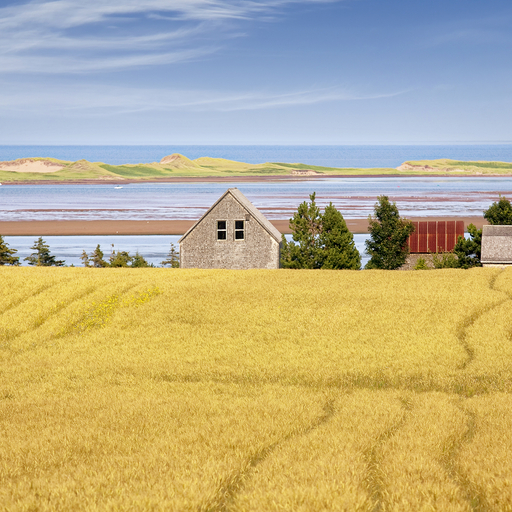

In [65]:
import requests
import io

a_url = 'https://www.ryugaku-johokan.com/blog/wp-content/uploads/2018/01/shutterstock_318930842.jpg'
a_img = Image.open(io.BytesIO(requests.get(a_url).content))
a_img.save("a_img.png")
init_image0 = crop_center(a_img,512,512)
init_image0

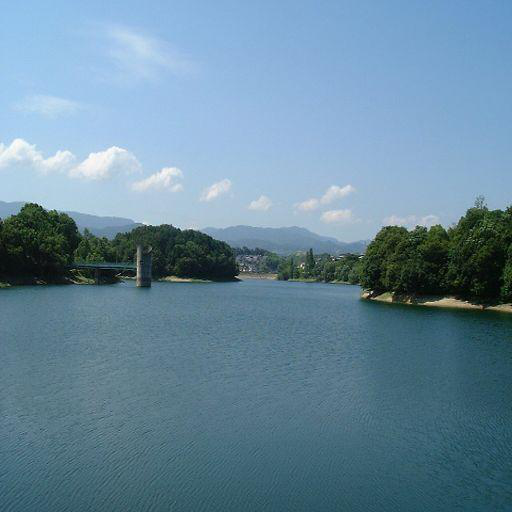

In [66]:
c_url = 'https://i.imgur.com/2p7WiX4.jpeg'
c_img = Image.open(io.BytesIO(requests.get(c_url).content))
c_img.save("c_img.png")
init_image = crop_center(c_img,512,512)
init_image

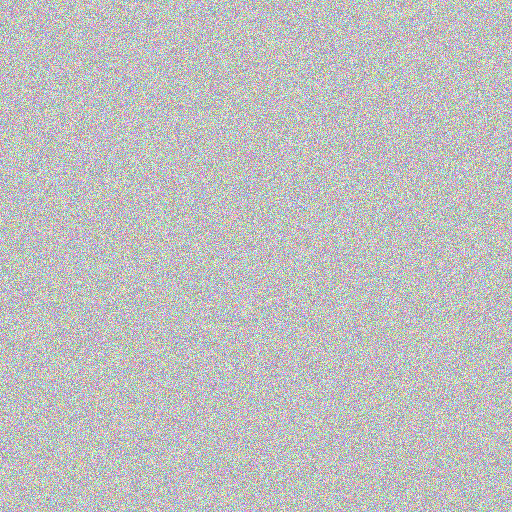

In [73]:
import PIL.Image as Image
noise=np.random.randint(0,128,(512,512,3))+128
noise[noise<0]=0
noise[noise>255]=255
noise=noise.astype(np.uint8)
noise=Image.fromarray(noise)
noise.save("noise0.png")
noise

In [68]:
#@title Run the Stable Diffusion pipeline
#@markdown Don't forget to use the placeholder token in your prompt

from torch import autocast

#pipe = StableDiffusionPipeline.from_pretrained(
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    init_image=init_image0,
    tokenizer=tokenizer,
    use_auth_token=True,
    crop = True,
).to("cuda")
pipe.enable_attention_slicing()

{'trained_betas'} was not found in config. Values will be initialized to default values.


  0%|          | 0/41 [00:00<?, ?it/s]

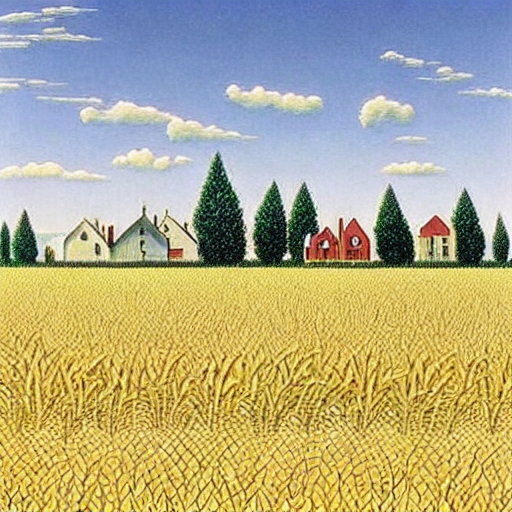

In [69]:
prompt = "A heartwarming Canadian wheat field scene in \u003Cm-mi2i> style, some houses in \u003Cm-mi2i> style, silos, and a lake in the distance" #@param {type:"string"}

num_samples = 1 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows*num_samples):
  with autocast("cuda"):
      images = pipe([prompt],num_inference_steps=50, guidance_scale=7.5,init_image=init_image0)["sample"]
      all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

# gradio によるデモ

In [70]:
!pip install -q gradio

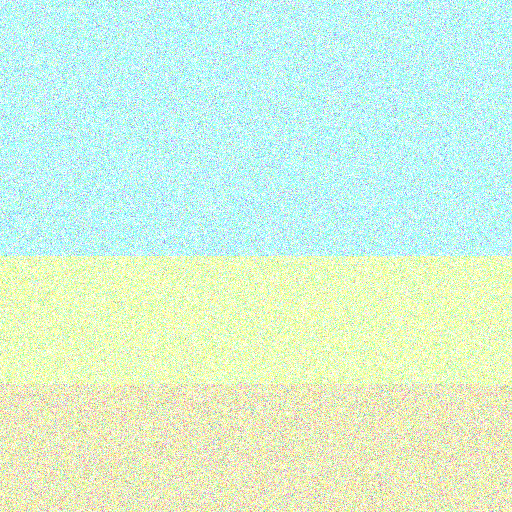

In [74]:
import PIL.Image as Image
noise=np.random.randint(0,128,(512,512,3))+128
noise[:256,:,2]=noise[:256,:,2]+np.random.randint(0,256,(256,512))
noise[:256,:,1]=noise[:256,:,1]+np.random.randint(0,256,(256,512))
noise[256:384,:,1]=noise[256:384,:,1]+np.random.randint(0,128,(128,512))+8
noise[256:,:,1]=noise[256:,:,1]+np.random.randint(0,128,(256,512))
noise[256:,:,0]=noise[256:,:,0]+np.random.randint(0,128,(256,512))
noise[noise<0]=0
noise[noise>255]=255
noise=noise.astype(np.uint8)
noise=Image.fromarray(noise)
noise.save("noise1.png")
noise

In [76]:
import numpy as np
import gradio as gr

def inmm(init_image, prompt):
    (w,h) = init_image.size
    if w>h :
      init_image = init_image.crop(((w - h) // 2,0,(w-h)//2 + h,h))
      init_image = init_image.resize(512,512)

    with autocast("cuda"):
      image = pipe([prompt], num_inference_steps=50, guidance_scale=7, init_image=init_image)["sample"]
    return image[0]

demo = gr.Interface(inmm, inputs=[gr.Image(shape=(512, 512),type="pil"),gr.Textbox(lines=2, placeholder="どんな絵が欲しいか",value ="a heartwarming and calming landscape drawing in <m-mi2i> style")], outputs="image",
      examples=[["a_img.png", "A heartwarming Canadian wheat field scene in <m-mi2i> style, some houses, silos, and a lake in the distance"],
                ["c_img.png","A heartwarming Landscape on the lake, scenery mirrored on the lake, in <m-mi2i> style"],
                ["noise0.png","A heartwarming Landscape  of forest hill in <m-mi2i> style"],
                ["noise1.png","A heartwarming Landscape  of forest hill in <m-mi2i> style"]])
demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://20146.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f2d443ab050>,
 'http://127.0.0.1:7862/',
 'https://20146.gradio.app')